In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/tank/klundert/projects/cfdn/prfpy_cfdn/')
import os
import preprocess
import glob
import natsort
import cortex as cx
import numpy as np
import scipy as sp
from scipy.stats import sem
from scipy.stats import f_oneway
import scikit_posthocs as sp
import h5py
import nibabel as nb
from nilearn.surface import load_surf_data
import matplotlib.pyplot as plt
import scipy
import nibabel as nb
import seaborn as sns
import random
from scipy.stats import sem


In [3]:
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])
def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

def splitList(array):
    n = len(array)
    half = int(n/2) # py3
    return array[:half], array[n-half:]


def load_wang(space, wcard='{hem}.wang_{space}.label.gii',wangloc='/tank/klundert/fsphere/'):
    ldat,rdat=nb.load(os.path.join(wangloc,wcard.format(hem='L',space=space))),nb.load(os.path.join(wangloc,wcard.format(hem='R',space=space)))
    fulldat=np.concatenate([ldat.agg_data(),rdat.agg_data()])
    return fulldat

atlas_data = load_wang('HCP')

roi_index_dict = {
    'V1':  [1,  2], 'V2':  [3, 4], 'V3':  [5, 6], 'hV4':  7, 'VO1':  8, 'VO2':  9, 'PHC1':  10, 'PHC2':  11,
    'TO2':  12, 'TO1':  13, 'LO2':  14, 'LO1':  15, 'V3B':  16, 'V3A':  17, 'IPS0':  18, 'IPS1':  19, 'IPS2':  20, 'IPS3':  21, 'IPS4': 22,
    'IPS5':  23, 'SPL1':  24, 'FEF': 25}

roi_index_dict2 = {
    'V1':  [1,  2], 'V2':  [3, 4], 'V3':  [5, 6], 'V3AB':  [16, 17], 'hV4':  7, 'VO':  [8, 9], 'PHC':  [10, 11],
    'TO':  [12, 13], 'LO':  [14, 15], 'IPS':  [18, 19, 20, 21, 22, 23], 'SPL1':  24, 'FEF': 25}


roimask = np.isin(atlas_data, roi_index_dict['V2'])
for l, ROI in enumerate(list(roi_index_dict)[1:]):
    roimask = np.isin(atlas_data, roi_index_dict[ROI]) + roimask
    
V3mask = np.isin(atlas_data, roi_index_dict['V3'])


In [4]:
roi_index_dict2 = {
    'V1':  [1,  2], 'V2':  [3, 4], 'V3':  [5, 6], 'hV4':  7, 'VO1':  8, 'VO2':  9, 'PHC1':  10, 'PHC2':  11,
    'TO2':  12, 'TO1':  13, 'LO2':  14, 'LO1':  15, 'V3B':  16, 'V3A':  17, 'IPS0':  18, 'IPS1':  19, 'IPS2':  20, 'IPS3':  21, 'IPS4': 22,
    'IPS5':  23, 'SPL1':  24, 'FEF': 25}

# roi_index_dict2 = {
#     'V1':  [1,  2], 'V2':  [3, 4], 'V3':  [5, 6], 'V3AB':  [16, 17], 'hV4':  7, 'VO':  [8, 9], 'PHC':  [10, 11],
#     'TO':  [12, 13], 'LO':  [14, 15], 'IPS':  [18, 19, 20, 21, 22, 23], 'SPL1':  24, 'FEF': 25}

In [5]:
# get dictionaries

psub = 2
fold = 1

brainmask = np.load(f'/tank/klundert/DMs/brainmask_sub-0{psub}.npy')
zsc_data = get_cortex(np.load(f'/tank/klundert/fit_data/fit_data/data_fold2_detrend_sub-0{psub}_zsc_hcp.npy'))
psc_data = get_cortex(np.load(f'/tank/klundert/fit_data/fit_data/data_fold2_detrend_sub-0{psub}_psc_hcp.npy'))

prf_gauss = get_cortex(np.load(f'/tank/klundert/data_hcp-space_cf/pRF-params_sub-0{psub}_gauss_weighted_fold-0{fold}.npy'))
prf_gauss[~brainmask] = np.nan
# Create a list of parameter names
parameter_names = ['x', 'y', 'pRF size', 'amplitude', 'bold-baseline', 'hrf1', 'hrf2', 'rsq']

# Create a Pandas dataframe and set the column names to the parameter names
prf_gauss = pd.DataFrame(prf_gauss, columns=parameter_names)

# Set the index to be the measurement number
prf_gauss.index = range(prf_gauss.shape[0])

# Print the resulting dataframe
# print(prf_gauss)

prf_dn = get_cortex(np.load(f'/tank/klundert/data_hcp-space_cf/pRF-params_sub-0{psub}_norm_weighted_fold-0{fold}.npy'))
prf_dn[~brainmask] = np.nan

parameter_names = ['x', 'y', 'pRF size', 'amplitude', 'bold baseline', 'surr amp', 'surr size', 'B', 'D', 'hrf1', 'hrf2', 'rsq']
prf_dn = pd.DataFrame(prf_dn, columns=parameter_names)
prf_dn.index = range(prf_dn.shape[0])

cf_gauss = np.zeros([118584, 7])
cf_gauss[:] = np.nan
cf_gauss[brainmask] = np.load(f'/tank/klundert/data_hcp-space_cf/CF-params_sub-0{psub}_gauss_weighted_fullbrain_fold-0{fold}.npy')
parameter_names = ['cf size', 'cf amp', 'bold baseline', 'vert', 'rsq', 'x', 'y']
cf_gauss = pd.DataFrame(cf_gauss, columns=parameter_names)
cf_gauss.index = range(cf_gauss.shape[0])

cf_dn = np.zeros([118584, 11])
cf_dn[:] = np.nan
cf_dn[brainmask] = np.load(f'/tank/klundert/data_hcp-space_cf/CF-params_sub-0{psub}_norm_weighted_fullbrain_fold-0{fold}.npy')
parameter_names = ['cf size', 'cf amp', 'bold baseline', 'vert', 'surr amp', 'surr size', 'B', 'D', 'rsq', 'x', 'y']
cf_dn = pd.DataFrame(cf_dn, columns=parameter_names)
cf_dn.index = range(cf_dn.shape[0])


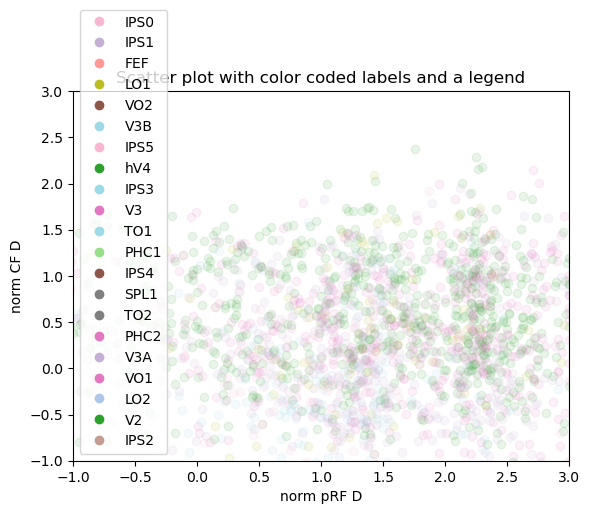

In [94]:
data = {}
for l, ROI in enumerate(list(roi_index_dict2)[1:]):
    boolmask = np.isin(atlas_data, roi_index_dict2[ROI])
    rsqm = (cf_dn['rsq'][boolmask] > 0.5) * (prf_dn['rsq'][boolmask] > 0.5)
    data.update({f'{ROI}': {'x': np.log10(prf_dn['B'][boolmask][rsqm]), 'y': np.log10(cf_dn['B'][boolmask][rsqm])}})

# get a list of unique labels in the data
labels = list(set(data.keys()))

# create a list of random colors, one for each label
colors = [plt.cm.tab20(random.choice(range(20))) for _ in range(len(labels))]

# create empty lists to store the plotted points for each label
plots = {label: [] for label in labels}

# loop through the data and plot each point with the appropriate color
for label, values in data.items():
    color = colors[labels.index(label)]
    plot = plt.scatter(values['x'], values['y'], color=color, alpha=0.1)
    plots[label].append(plot)

# create the legend
legend_elements = [plt.Line2D([], [], marker='o', color=color, label=label, linestyle='None')
                   for label, color in zip(labels, colors)]
plt.legend(handles=legend_elements)

# add labels and title to the plot
plt.ylabel('norm CF D')
plt.xlabel('norm pRF D')
plt.xlim([-1,3])
plt.ylim([-1,3])
plt.title('Scatter plot with color coded labels and a legend')

# show the plot
plt.show()


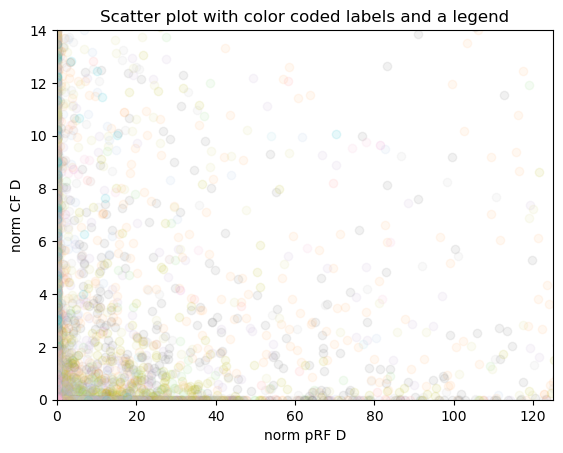

In [60]:
data = {}
for l, ROI in enumerate(list(roi_index_dict2)[1:]):
    boolmask = np.isin(atlas_data, roi_index_dict2[ROI])
    rsqm = (cf_dn['rsq'][boolmask] > 0.15) + (prf_dn['rsq'][boolmask] > 0.15)
    data.update({f'{ROI}': {'x': prf_dn['B'][boolmask][rsqm], 'y': cf_dn['B'][boolmask][rsqm]}})

# get a list of unique labels in the data
labels = list(set(data.keys()))

# create a list of random colors, one for each label
colors = [plt.cm.tab20(random.choice(range(20))) for _ in range(len(labels))]

# create empty lists to store the plotted points for each label
plots = {label: [] for label in labels}

# loop through the data and plot each point with the appropriate color
for label, values in data.items():
    color = colors[labels.index(label)]
    plot = plt.scatter(values['x'], values['y'], color=color, alpha=0.1)
    plots[label].append(plot)

# create the legend
legend_elements = [plt.Line2D([], [], marker='o', color=color, label=label, linestyle='None')
                   for label, color in zip(labels, colors)]
# plt.legend(handles=legend_elements)

# add labels and title to the plot
plt.ylabel('norm CF D')
plt.xlabel('norm pRF D')
plt.xlim([0,125])
plt.ylim([0,14])
plt.title('Scatter plot with color coded labels and a legend')

# show the plot
plt.show()


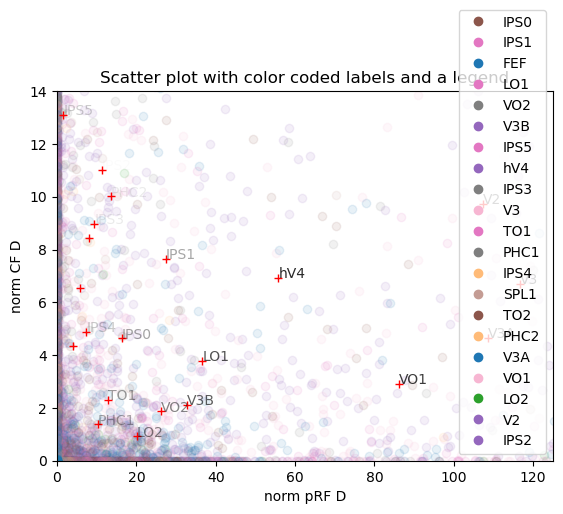

In [82]:
means_prf_b = []
means_cf_b = []
error_prf = []
error_cf = []
data = {}
means_rsq = []

plt.figure()

for l, ROI in enumerate(list(roi_index_dict2)[1:]):
    boolmask = np.isin(atlas_data, roi_index_dict2[ROI])
    
    rsqm = (cf_dn['rsq'][boolmask] > 0.15) + (prf_dn['rsq'][boolmask] > 0.15)
    means_rsq.append(np.nanmean(cf_dn['rsq'][boolmask]))
    means_cf_b.append(np.nanmean(cf_dn['B'][boolmask][rsqm]))
    means_prf_b.append(np.nanmean(prf_dn['B'][boolmask][rsqm]))
    error_cf.append(sem(np.nan_to_num(cf_dn['B'][boolmask][rsqm])))
    error_prf.append(sem(np.nan_to_num(prf_dn['B'][boolmask][rsqm])))
    data.update({f'{ROI}': {'x': prf_dn['B'][boolmask][rsqm], 'y': cf_dn['B'][boolmask][rsqm]}})

    
plt.plot(means_prf_b, means_cf_b, 'r+')
plt.ylabel('norm CF D')
plt.xlabel('norm pRF D')
plt.title(f'sub-0{psub} D param')


means_rsq = np.array(means_rsq)
means_rsq[means_rsq < 0] = 0
# means_rsq[means_rsq < 0] = 0
for l, ROI in enumerate(list(roi_index_dict2)[1:]):
    plt.annotate(ROI, (means_prf_b[l], means_cf_b[l]), alpha=means_rsq[l])
    
    
labels = list(set(data.keys()))

# create a list of random colors, one for each label
colors = [plt.cm.tab20(random.choice(range(20))) for _ in range(len(labels))]

# create empty lists to store the plotted points for each label
plots = {label: [] for label in labels}

# loop through the data and plot each point with the appropriate color
for label, values in data.items():
    color = colors[labels.index(label)]
    plot = plt.scatter(values['x'], values['y'], color=color, alpha=0.1)
    plots[label].append(plot)

# create the legend
legend_elements = [plt.Line2D([], [], marker='o', color=color, label=label, linestyle='None')
                   for label, color in zip(labels, colors)]
plt.legend(handles=legend_elements)

# add labels and title to the plot
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.title('Scatter plot with color coded labels and a legend')
plt.xlim([0,125])
plt.ylim([0,14])
# show the plot
plt.show()

/tmp/ipykernel_2025164/2417495481.py:18: RuntimeWarning: divide by zero encountered in log
  error_prf.append(sem(np.log(np.nan_to_num(prf_dn['B'][boolmask][rsqm]))))
/tmp/ipykernel_2025164/2417495481.py:17: RuntimeWarning: divide by zero encountered in log
  error_cf.append(sem(np.log(np.nan_to_num(cf_dn['B'][boolmask][rsqm]))))
/tmp/ipykernel_2025164/2417495481.py:18: RuntimeWarning: invalid value encountered in log
  error_prf.append(sem(np.log(np.nan_to_num(prf_dn['B'][boolmask][rsqm]))))


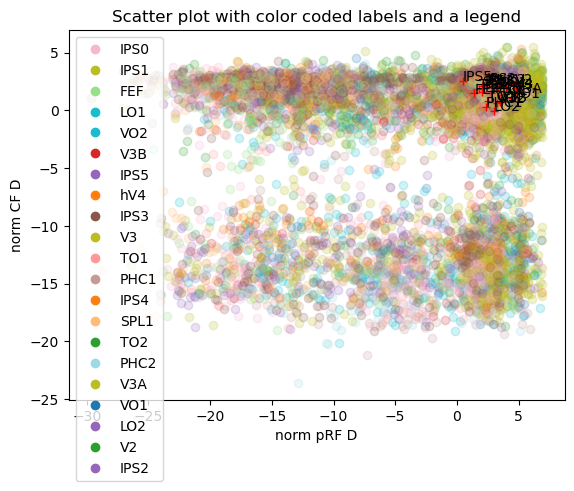

In [45]:
means_prf_b = []
means_cf_b = []
error_prf = []
error_cf = []
data = {}


plt.figure()

for l, ROI in enumerate(list(roi_index_dict2)[1:]):
    boolmask = np.isin(atlas_data, roi_index_dict2[ROI])
    
    rsqm = (cf_dn['rsq'][boolmask] > 0.15) + (prf_dn['rsq'][boolmask] > 0.15)
    
    means_cf_b.append(np.log(np.nanmean(cf_dn['B'][boolmask][rsqm])))
    means_prf_b.append(np.log(np.nanmean(prf_dn['B'][boolmask][rsqm])))
    error_cf.append(sem(np.log(np.nan_to_num(cf_dn['B'][boolmask][rsqm]))))
    error_prf.append(sem(np.log(np.nan_to_num(prf_dn['B'][boolmask][rsqm]))))
    # data.update({f'{ROI}': {'x': prf_dn['B'][boolmask][rsqm], 'y': cf_dn['B'][boolmask][rsqm]}})
    data.update({f'{ROI}': {'x': np.log(prf_dn['B'][boolmask][rsqm]), 'y': np.log(cf_dn['B'][boolmask][rsqm])}})

plt.plot(means_prf_b, means_cf_b, 'r+')
plt.ylabel('norm CF D')
plt.xlabel('norm pRF D')
plt.title(f'sub-0{psub} D param')
for l, ROI in enumerate(list(roi_index_dict2)[1:]):
    plt.annotate(ROI, (means_prf_b[l], means_cf_b[l]))
    
    
labels = list(set(data.keys()))

# create a list of random colors, one for each label
colors = [plt.cm.tab20(random.choice(range(20))) for _ in range(len(labels))]

# create empty lists to store the plotted points for each label
plots = {label: [] for label in labels}

# loop through the data and plot each point with the appropriate color
for label, values in data.items():
    color = colors[labels.index(label)]
    plot = plt.scatter(values['x'], values['y'], color=color, alpha=0.2)
    plots[label].append(plot)

# create the legend
legend_elements = [plt.Line2D([], [], marker='o', color=color, label=label, linestyle='None')
                   for label, color in zip(labels, colors)]
plt.legend(handles=legend_elements)

# add labels and title to the plot
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.title('Scatter plot with color coded labels and a legend')

# show the plot
plt.show()